In [ ]:
# Nama: Hajid Lutfi Hidayanto
# Email: hajidlutfi@gmail.com
# Asal: Kulon Progo
# Domisili: Surakarta

# Link dataset: https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs/data

In [13]:
# import library yang dibutuhkan
from sklearn.model_selection import train_test_split
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile,os,shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from PIL import Image
import os
import pathlib

In [2]:
# mount/load google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# melakukan ekstraksi pada file zip
zip_file_path = '/content/drive/MyDrive/Datasets/catDog.zip'
extract_path = '/content'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
# menghitung gambar dengan dimensi berbeda di directory test_set/cats
directory = '/content/dataset/test_set/cats'

dimension_count = {}

for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            width, height = img.size
            dimensions = (width, height)

            if dimensions in dimension_count:
                dimension_count[dimensions] += 1
            else:
                dimension_count[dimensions] = 1

if len(dimension_count) > 1:
    print(f'Ada {len(dimension_count)} gambar yang berbeda dimensi')


Ada 582 gambar yang berbeda dimensi


In [5]:
train_dir = '/content/dataset/training_set'
test_dir = '/content/dataset/test_set'

# Menghitung jumlah sampel data
train_len = len(os.listdir(train_dir + '/cats')) + len(os.listdir(train_dir + '/dogs'))
test_len = len(os.listdir(test_dir + '/cats')) + len(os.listdir(test_dir + '/dogs'))
print(f"Jumlah sample dataset\nTrain: {train_len}\nTest: {test_len}\nTotal: {train_len + test_len}")

Jumlah sample dataset
Train: 8000
Test: 2000
Total: 10000


In [6]:
# AUGMENTASI GAMBAR
# augmentasi untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# untuk test set hanya rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# generator loading gambar dari directory train
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

# generator loading gambar dari directory train
val_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')
train_generator.class_indices

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [7]:
# MEMBUAT MODEL
vgg_tl = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_tl.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    # terdapat maxpoolling dan convolutional layers dalam vgg16
    vgg_tl,
    # Flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # Dropout untuk regularization
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    # Dropout untuk regularization
    tf.keras.layers.Dropout(0.3),
    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                         

In [8]:
# COMPILE DAN MELATIH MODEL
# Compile
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1.000e-5),
              metrics=['accuracy'])

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print("\nAkurasi sudah di atas 92%!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
# Melatih
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/20
125/125 - 140s - loss: 0.6114 - accuracy: 0.6639 - val_loss: 0.4249 - val_accuracy: 0.8543 - 140s/epoch - 1s/step
Epoch 2/20
125/125 - 123s - loss: 0.4157 - accuracy: 0.8186 - val_loss: 0.3166 - val_accuracy: 0.8785 - 123s/epoch - 987ms/step
Epoch 3/20
125/125 - 123s - loss: 0.3360 - accuracy: 0.8597 - val_loss: 0.2713 - val_accuracy: 0.8901 - 123s/epoch - 987ms/step
Epoch 4/20
125/125 - 123s - loss: 0.3019 - accuracy: 0.8751 - val_loss: 0.2467 - val_accuracy: 0.8952 - 123s/epoch - 984ms/step
Epoch 5/20
125/125 - 124s - loss: 0.2731 - accuracy: 0.8881 - val_loss: 0.2290 - val_accuracy: 0.9057 - 124s/epoch - 992ms/step
Epoch 6/20
125/125 - 124s - loss: 0.2520 - accuracy: 0.8990 - val_loss: 0.2175 - val_accuracy: 0.9073 - 124s/epoch - 990ms/step
Epoch 7/20
125/125 - 125s - loss: 0.2412 - accuracy: 0.9019 - val_loss: 0.2094 - val_accuracy: 0.9123 - 125s/epoch - 1s/step
Epoch 8/20
125/125 - 123s - loss: 0.2243 - accuracy: 0.9091 - val_loss: 0.2027 - val_accuracy: 0.9123 - 123s/e

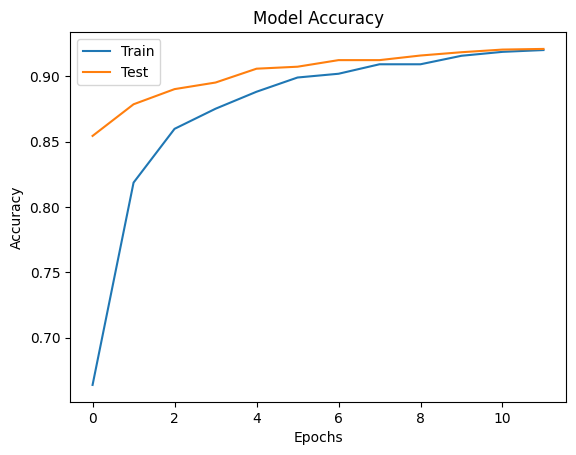

In [11]:
# Plot accuracy model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

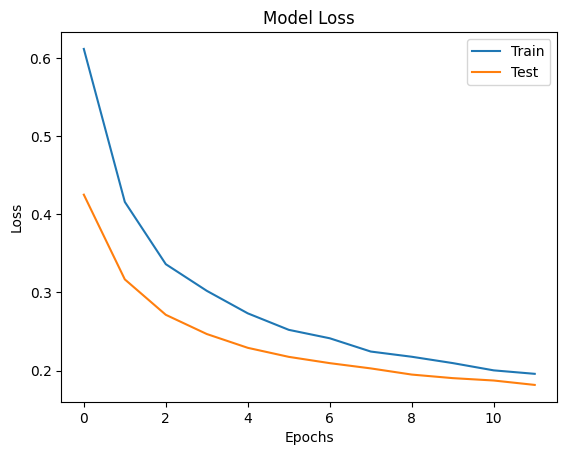

In [12]:
# Plot loss model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [14]:
# menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# mengubah SavedModel menjadi tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

84824904